In [24]:
import numpy as np
import os
import sys
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive

In [2]:
# Load a stock's historical data from Huge Stock Market Dataset
def load_data(filename):
    with open(filename) as f:
        header = f.readline()
        points = []
        for line in f.readlines():
            data = line.split(',')
            # Extract relevant features
            open_price = float(data[1])
            high_price = float(data[2])
            low_price = float(data[3])
            close_price = float(data[4])
            volume = int(data[5])
            # Append the data point to the list
            points.append([open_price, high_price, low_price, close_price, volume])
    return np.array(points)

# Load data from Google Drive
drive.mount('/content/drive')

# Append the data set directory to your Python path using sys
prefix = '/content/drive/My Drive/'
customized_path = 'Colab Notebooks/archive/Data/Stocks'
sys_path = prefix + customized_path
sys.path.append(sys_path)
data = os.path.join(sys_path, )
print(sys.path)

Mounted at /content/drive
['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/Colab Notebooks/archive/Data/Stocks']


In [20]:
import random

stock_labels = []
stock_data = []
count = 0

# Get list of filenames
filenames = [filename for filename in os.listdir(sys_path) if os.path.isfile(os.path.join(sys_path, filename))]

# Shuffle the list of filenames
random.shuffle(filenames)

# Load data for each stock
for filename in filenames[:len(filenames)//20]: # only 1/20th of the dataset is loaded
    ticker_symbol = os.path.splitext(filename)[0]
    stock_labels.append(ticker_symbol.upper())
    try:
        stock_data.append(load_data(os.path.join(sys_path, filename)))
        count += 1
    except FileNotFoundError as e:
        continue

print(count)


360


In [21]:
# Normalize the data
scalers = {}
scaled_data = []
for data in stock_data:
    if len(data) > 0:  # Check if data is not empty
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data.append(scaler.fit_transform(data))
        scalers[ticker_symbol] = scaler
    else:
        continue


# Prepare the data
# Assume a fixed sequence length
sequence_length = 10
X_train = []
y_train = []
for data in scaled_data:
    for i in range(len(data) - sequence_length):
        X_train.append(data[i:i+sequence_length])
        y_train.append(data[i+sequence_length])

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [22]:
def data_generator(batch_size, stock_data):
    num_samples = len(stock_data)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_data = stock_data[offset:offset+batch_size]
            X_batch = []
            y_batch = []
            for data in batch_data:
                # Process data as needed (e.g., scaling)
                # Assuming data is a tuple (X, y)
                X, y = data
                X_batch.append(X)
                y_batch.append(y)
            yield np.array(X_batch), np.array(y_batch)

Epoch 1/20
15063/15063 [==============================] - 128s 8ms/step - loss: 0.0015 - accuracy: 0.4051 - mean_absolute_error: 0.0235 - val_loss: 7.5261e-04 - val_accuracy: 0.4801 - val_mean_absolute_error: 0.0154
Epoch 2/20
15063/15063 [==============================] - 121s 8ms/step - loss: 0.0011 - accuracy: 0.4235 - mean_absolute_error: 0.0206 - val_loss: 6.4235e-04 - val_accuracy: 0.4823 - val_mean_absolute_error: 0.0121
Epoch 3/20
15063/15063 [==============================] - 138s 9ms/step - loss: 0.0011 - accuracy: 0.4276 - mean_absolute_error: 0.0201 - val_loss: 6.6475e-04 - val_accuracy: 0.5102 - val_mean_absolute_error: 0.0139
Epoch 4/20
15063/15063 [==============================] - 123s 8ms/step - loss: 0.0010 - accuracy: 0.4310 - mean_absolute_error: 0.0199 - val_loss: 6.1724e-04 - val_accuracy: 0.4959 - val_mean_absolute_error: 0.0114
Epoch 5/20
15063/15063 [==============================] - 121s 8ms/step - loss: 0.0010 - accuracy: 0.4343 - mean_absolute_error: 0.0197 

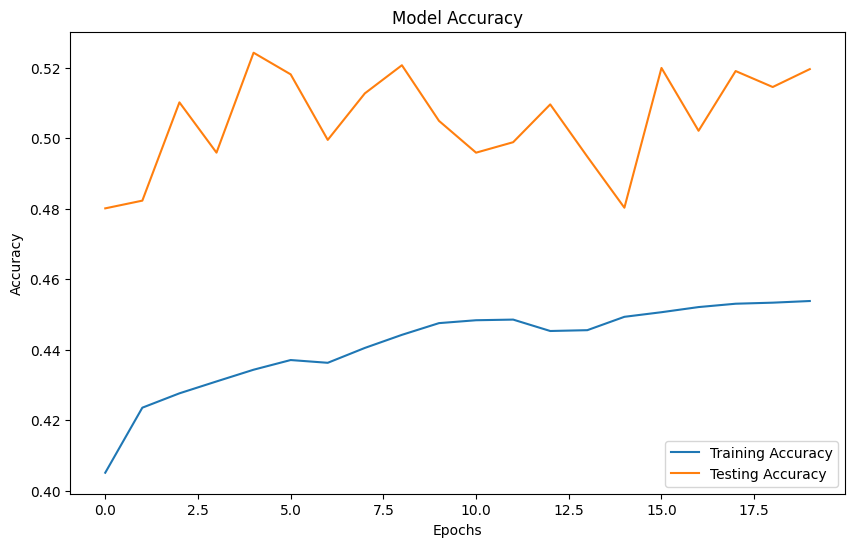

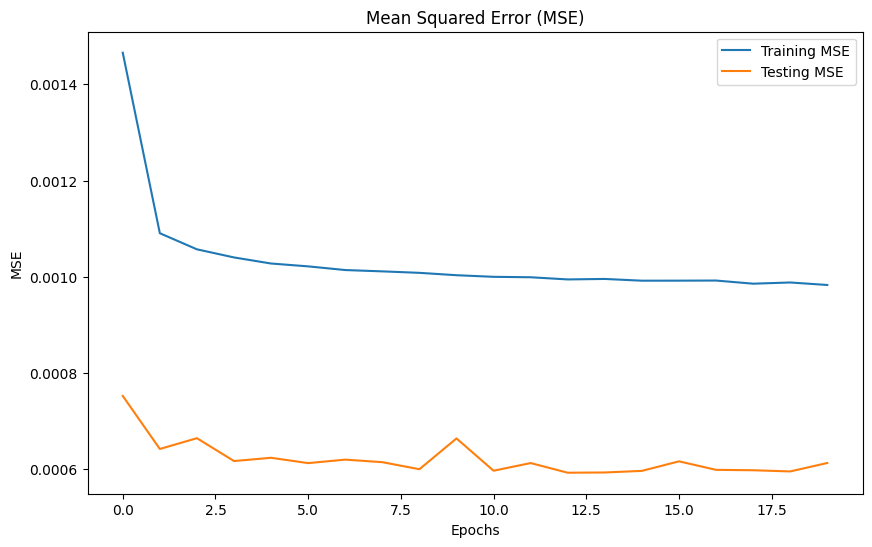

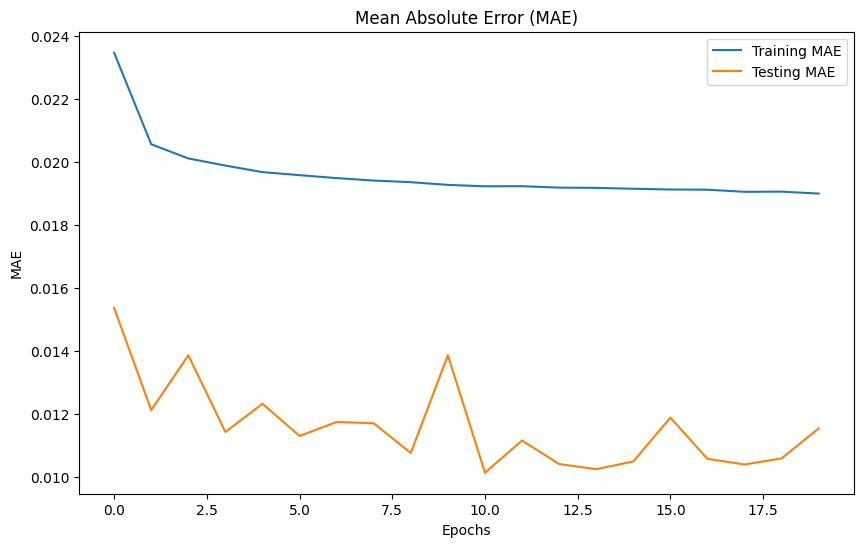

In [23]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Input, LSTM, Dropout, Dense, Concatenate
import matplotlib.pyplot as plt
from keras.callbacks import Callback

# Custom callback to record training and testing accuracy
class AccuracyHistory(Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Add dropout layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))  # Add dropout layer
model.add(Dense(units=5))  # Adjust units according to the number of features
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy', 'mean_absolute_error'])

# Defined batch size
batch_size = 32

# Define number of epochs
num_epochs = 20

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Custom callback to record training and testing accuracy
accuracy_history = AccuracyHistory()

# Convert training data to a list of tuples
train_data = list(zip(X_train, y_train))

# Generates data batches
train_generator = data_generator(batch_size, train_data)
steps_per_epoch = len(train_data) // batch_size  # Number of batches per epoch

# Train the model using Model.fit
history = model.fit(train_generator, epochs=num_epochs, steps_per_epoch=steps_per_epoch, validation_data=(X_test, y_test), callbacks=[accuracy_history])

# Make predictions using the model
predictions = model.predict(X_test)
print(predictions)

# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

# Plotting training and testing accuracy
plt.figure(figsize=(10, 6))
plt.plot(accuracy_history.acc, label='Training Accuracy')
plt.plot(accuracy_history.val_acc, label='Testing Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting Mean Squared Error (MSE)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Testing MSE')
plt.title('Mean Squared Error (MSE)')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Plotting Mean Absolute Error (MAE)
plt.figure(figsize=(10, 6))
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Testing MAE')
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()
